# Scenario 1

## Aim

- Use `SequentialFeatureSelector` to determine the most important numerical features.
- Scoring metric: $R^2$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
# Prevent "None" from being read as NA
# Read MSSubClass as categorical rather than numeric
df = pd.read_csv(
    "../data/ames_housing_clean_1.csv",
    keep_default_na=False,  
    na_values=["", " "],
    dtype={'MSSubClass': 'str'}
)

In [3]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('PID')  # Remove ID column
numerical_features.remove('SalePrice') # Remove target from features

print(f"Number of numerical features: {len(numerical_features)}")
print(f"First few numerical features: {numerical_features[:5]}")

Number of numerical features: 34
First few numerical features: ['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']


## Top 5 Numerical

Use SequentialFeatureSelector to select 5 best features

In [4]:
X = df[numerical_features]
y = df['SalePrice']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sfs = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select=5,
    direction='forward',
    scoring='r2',
    cv=5,
    n_jobs=-1
)

In [5]:
sfs.fit(X_train_scaled, y_train)
selected_indices = sfs.get_support(indices=True)
selected_features = [numerical_features[i] for i in selected_indices]

print(f"Top 5 features selected: {selected_features}")

Top 5 features selected: ['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea']


In [6]:
# Evaluate the model with selected features only
X_train_selected = X_train_scaled[:, selected_indices]
X_test_selected = X_test_scaled[:, selected_indices]

model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

In [7]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [8]:
print(f"Model performance with top 5 features only:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

Model performance with top 5 features only:
Mean Squared Error: 970004936.53
R² Score: 0.8307


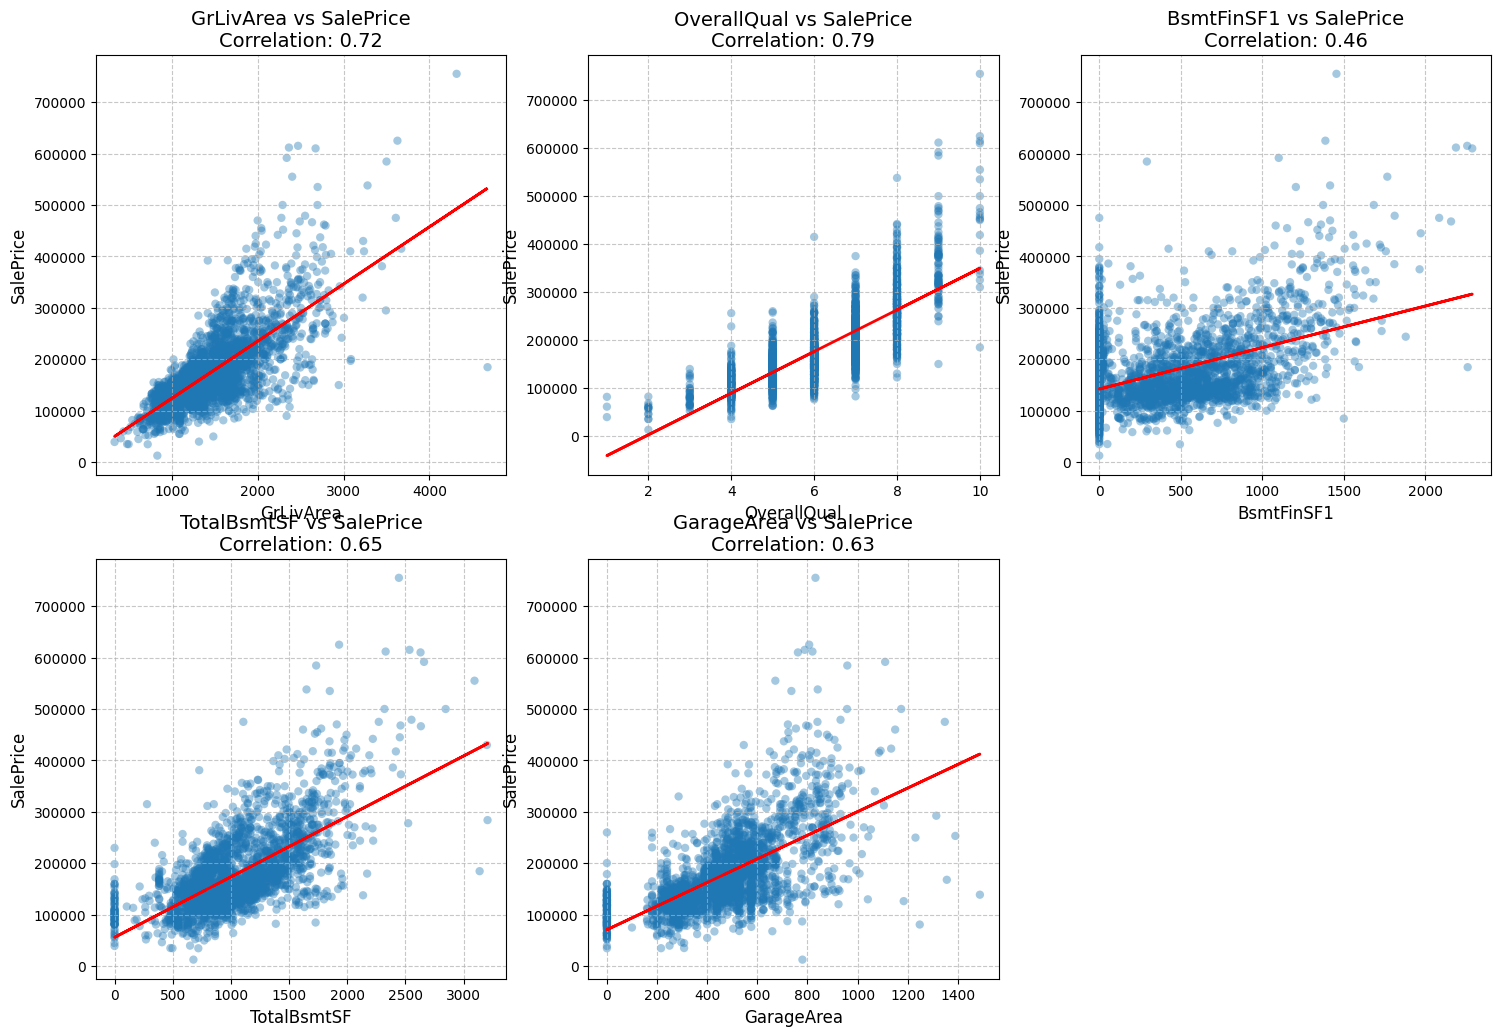

In [9]:
# Set up the figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Create scatterplots for each feature
for i, feature in enumerate(selected_features):
    ax = axes[i]
    
    correlation, _ = pearsonr(df[feature], df['SalePrice'])
    
    ax.scatter(df[feature], df['SalePrice'], alpha=0.4, edgecolor='none')
    
    # Add regression line
    x = df[feature]
    y = df['SalePrice']
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='red', linewidth=2)
    
    ax.set_title(f'{feature} vs SalePrice\nCorrelation: {correlation:.2f}', fontsize=14)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('SalePrice', fontsize=12)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Format y-axis (removing scientific notation)
    ax.get_yaxis().get_major_formatter().set_scientific(False)

# Remove the empty subplot
if len(selected_features) < 6:
    fig.delaxes(axes[5])


In [10]:
selected_df = df[selected_features]

# Calculate VIF for each feature
# First, create a new DataFrame with a constant column
selected_df_with_constant = add_constant(selected_df)
vif_data = pd.DataFrame()
vif_data["Feature"] = selected_df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(selected_df_with_constant.values, i) 
                   for i in range(selected_df_with_constant.shape[1])]

In [11]:
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data

,Feature,VIF
0,const,21.20
1,GrLivArea,1.60
2,OverallQual,1.87
3,BsmtFinSF1,1.38
4,TotalBsmtSF,1.84
5,GarageArea,1.60


## Auto find top numerical

Automatically select most important features with a tolerance of 0.5%

In [12]:
auto_sfs = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select="auto",
    direction='forward',
    scoring='r2',
    tol=0.005,
    cv=5,
    n_jobs=-1
)

In [13]:
auto_sfs.fit(X_train_scaled, y_train)
final_indices = auto_sfs.get_support(indices=True)
final_features = [numerical_features[i] for i in final_indices]

# Create and evaluate auto model
X_train_final = X_train_scaled[:, final_indices]
X_test_final = X_test_scaled[:, final_indices]

final_model = LinearRegression()
final_model.fit(X_train_final, y_train)
y_pred_final = final_model.predict(X_test_final)

final_mse = mean_squared_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)

print(f"Auto Model Performance:")
print(f"Number of features selected: {len(final_features)}")
print(f"Test MSE: {final_mse:,.2f}")
print(f"Test R²: {final_r2:.4f}")
print(f"Selected features: {final_features}")

Auto Model Performance:
Number of features selected: 7
Test MSE: 921,561,468.59
Test R²: 0.8392
Selected features: ['GrLivArea', 'OverallQual', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea']


In [26]:
# Compare auto with full model
full_model = LinearRegression()
full_model.fit(X_train_scaled, y_train)
y_pred_full = full_model.predict(X_test_scaled)

full_mse = mean_squared_error(y_test, y_pred_full)
full_r2 = r2_score(y_test, y_pred_full)

print("\nComparison with Full Model:")
print(f"Full model (all {len(numerical_features)} features) - MSE: {full_mse:.2f}, R²: {full_r2:.4f}")
print(f"Selected model ({len(final_features)} features) - MSE: {final_mse:.2f}, R²: {final_r2:.4f}")



Comparison with Full Model:
Full model (all 34 features) - MSE: 761754286.65, R²: 0.8671
Selected model (7 features) - MSE: 921561468.59, R²: 0.8392


In [27]:
selected_df = df[final_features]

# Calculate VIF for each feature
# First, create a new DataFrame with a constant column
selected_df_with_constant = add_constant(selected_df)
vif_data = pd.DataFrame()
vif_data["Feature"] = selected_df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(selected_df_with_constant.values, i) 
                   for i in range(selected_df_with_constant.shape[1])]

In [28]:
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data

,Feature,VIF
0,const,12900.54
1,GrLivArea,1.65
2,OverallQual,2.33
3,YearRemodAdd,1.45
4,MasVnrArea,1.32
5,BsmtFinSF1,1.40
6,TotalBsmtSF,1.86
7,GarageArea,1.62


In [14]:
final_features

['GrLivArea',
 'OverallQual',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'GarageArea']